In [59]:
# indispensable libraries
import numpy as np
import re
import pandas as pd
#pd.options.display.max_columns = None

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D 
#from IPython.display import HTML

# clustering algorithms, ML metrics and optimization
from sklearn.cluster import KMeans#, MiniBatchKMeans, DBSCAN, OPTICS, AffinityPropagation, Birch, AgglomerativeClustering, \
                           # SpectralClustering, MeanShift
#from scipy.cluster import hierarchy
#from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, make_scorer
#from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import NearestNeighbors
#from kneed import KneeLocator

# data transformation
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

# data reduction
from sklearn.decomposition import PCA

#import warnings
#warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv("HistorialCrediticio.csv")

In [61]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [62]:
df.shape

(8950, 18)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [64]:
df.isna().sum(axis = 0)

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [65]:
df.dropna(inplace= True)

In [66]:
#Se modifican los nombres de todas las columnas para darles un formato mas corto y amigable.
old_names = df.columns.tolist()
new_names = ['cust_id', 'balance', 'bal_freq', 'purchases', 'oneoff_purch', 'inst_purch', 'cash_adv', 'purch_freq', 
             'oneoff_purch_freq', 'inst_purch_freq', 'cash_adv_freq', 'cash_adv_trx', 'purch_trx', 'credit_lim',
             'payments', 'min_payments', 'prc_full_pay', 'tenure']

df.rename(columns = dict(zip(old_names, new_names)), inplace = True)

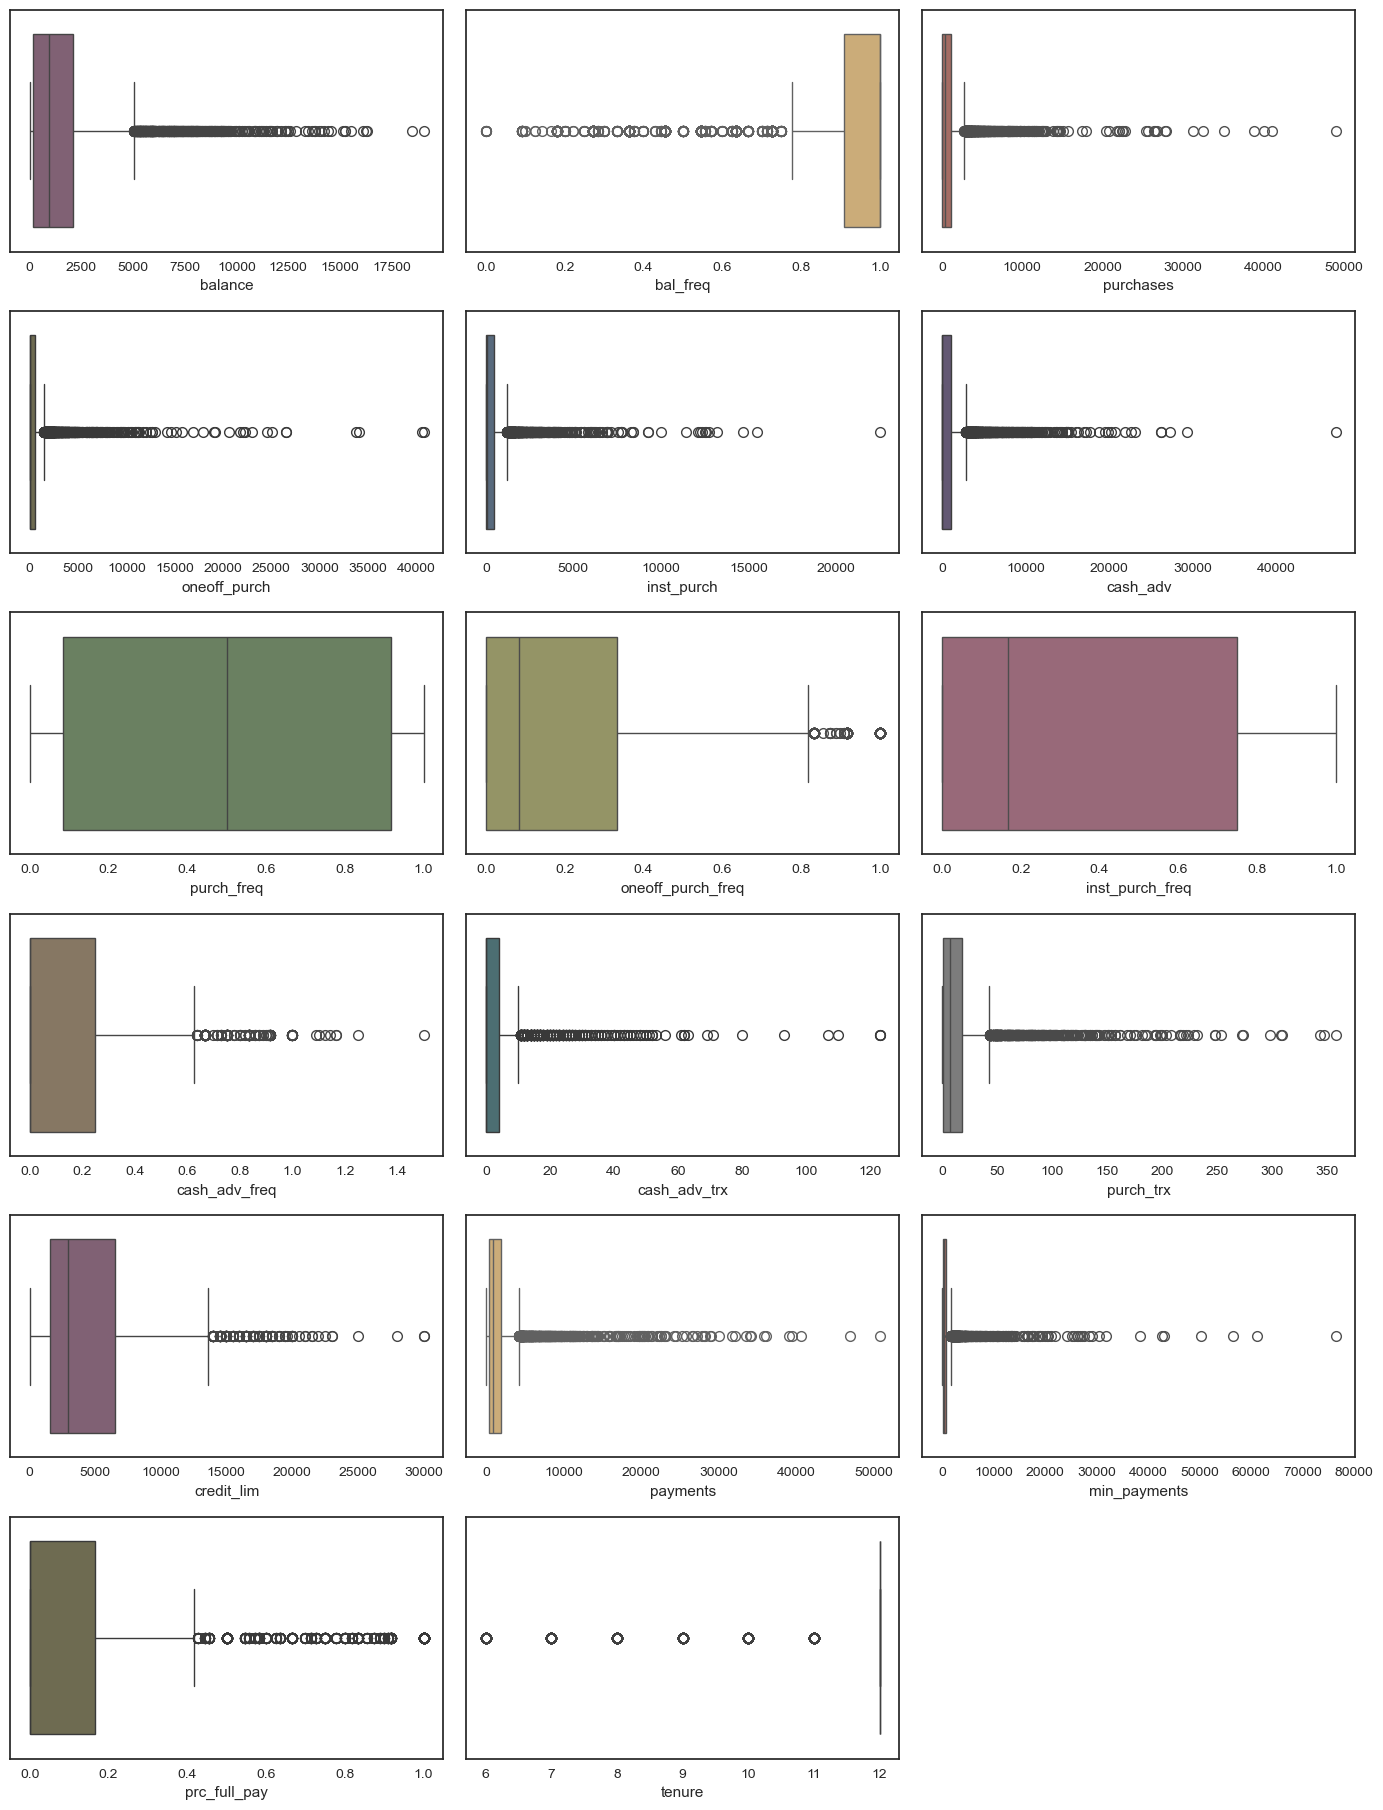

In [67]:
#Aqui veremos como es la distribucion de los datos para ver si hay outliers que puedan entorpecer el modelo.

num_columns = df.select_dtypes(include=['int64', 'float64']).columns

antique_palette = ['#855C75FF', '#D9AF6BFF', '#AF6458FF', '#736F4CFF', '#526A83FF', '#625377FF', '#68855CFF', '#9C9C5EFF', 
                   '#A06177FF', '#8C785DFF', '#467378FF', '#7C7C7CFF']

sns.set_style('white')
plt.figure(figsize = (14, len(num_columns) * 3))

for idx, feature in enumerate(num_columns, 1):
    plt.subplot(len(num_columns), 3, idx)
    color_idx = (idx - 1) % len(antique_palette)
    sns.boxplot(data = df, x = feature, color = antique_palette[color_idx])

plt.tight_layout()
plt.show()

In [68]:
# Verificar cuántas filas quedan después de cada filtro
print(f"Filas antes del filtro: {df.shape}")

print(f"Filas después de 'balance < 15000': {df[df['balance'] < 15000].shape}")
df = df[df['balance'] < 15000]

print(f"Filas después de 'purchases < 15000': {df[df['purchases'] < 15000].shape}")
df = df[df['purchases'] < 15000]

print(f"Filas después de 'oneoff_purch < 13000': {df[df['oneoff_purch'] < 13000].shape}")
df = df[df['oneoff_purch'] < 13000]

print(f"Filas después de 'inst_purch < 1000': {df[df['inst_purch'] < 10000].shape}")
df = df[df['inst_purch'] < 10000]

print(f"Filas después de 'cash_adv < 24000': {df[df['cash_adv'] < 24000].shape}")
df = df[df['cash_adv'] < 24000]

print(f"Filas después de 'cash_adv_freq <= 1.0': {df[df['cash_adv_freq'] <= 1].shape}")
df = df[df['cash_adv_freq'] <= 1]  # Excepción, porque freq debería estar en el rango 0 - 1

print(f"Filas después de 'cash_adv_trx < 55': {df[df['cash_adv_trx'] < 60].shape}")
df = df[df['cash_adv_trx'] < 60]

print(f"Filas después de 'purch_trx < 240': {df[df['purch_trx'] < 240].shape}")
df = df[df['purch_trx'] < 240]

print(f"Filas después de 'credit_lim < 13500': {df[df['credit_lim'] < 20000].shape}")
df = df[df['credit_lim'] < 20000]

print(f"Filas después de 'payments < 23000': {df[df['payments'] < 23000].shape}")
df = df[df['payments'] < 23000]

print(f"Filas después de 'min_payments < 24000': {df[df['min_payments'] < 24000].shape}")
df = df[df['min_payments'] < 24000]

print(f"Filas después de 'prc_full_pay < 0.405': {df[df['prc_full_pay'] < 0.4].shape}")
df = df[df['prc_full_pay'] < 0.4]

# Filas finales después de todos los filtros
print(f"Filas finales después de todos los filtros: {df.shape}")


Filas antes del filtro: (8636, 18)
Filas después de 'balance < 15000': (8627, 18)
Filas después de 'purchases < 15000': (8602, 18)
Filas después de 'oneoff_purch < 13000': (8601, 18)
Filas después de 'inst_purch < 1000': (8596, 18)
Filas después de 'cash_adv < 24000': (8591, 18)
Filas después de 'cash_adv_freq <= 1.0': (8583, 18)
Filas después de 'cash_adv_trx < 55': (8571, 18)
Filas después de 'purch_trx < 240': (8564, 18)
Filas después de 'credit_lim < 13500': (8546, 18)
Filas después de 'payments < 23000': (8538, 18)
Filas después de 'min_payments < 24000': (8519, 18)
Filas después de 'prc_full_pay < 0.405': (7122, 18)
Filas finales después de todos los filtros: (7122, 18)


In [69]:
#Aqui mejor quite los outliers que se iban de cierto rango, no se hace con todas porque se perderia mucha info
df = df[(df['balance'] < 15000) &
        (df['purchases'] < 15000) &
        (df['oneoff_purch'] < 13000) &

        (df['inst_purch'] < 10000) &

        (df['cash_adv'] < 24000) &

        (df['cash_adv_freq'] <= 1) &
        (df['cash_adv_trx'] < 60) &
        (df['purch_trx'] < 240) &

        (df['credit_lim'] < 13500) &
        (df['payments'] < 23000) &

        (df['min_payments'] < 24000) &
        (df['prc_full_pay'] < 0.4)]


In [70]:
df.drop(["cust_id"], axis=1, inplace= True)

In [71]:
df.shape

(6965, 17)

In [72]:
#8637

In [73]:
df.shape

(6965, 17)

In [74]:
df.describe(include = ['float64', 'int64']).T

,count,mean,std,min,25%,50%,75%,max
balance,6965.0,1717.786262,1873.250473,0.000000,356.523710,1133.652007,2344.478291,12373.33348
bal_freq,6965.0,0.906244,0.199830,0.000000,0.909091,1.000000,1.000000,1.00000
purchases,6965.0,784.064441,1318.578610,0.000000,0.000000,294.750000,962.120000,13013.50000
oneoff_purch,6965.0,463.585664,987.591571,0.000000,0.000000,39.800000,505.480000,12650.00000
inst_purch,6965.0,320.758123,646.960048,0.000000,0.000000,27.160000,384.000000,8391.55000
cash_adv,6965.0,1069.398304,1930.695410,0.000000,0.000000,144.017573,1381.853089,20277.33112
purch_freq,6965.0,0.439661,0.397047,0.000000,0.000000,0.333333,0.875000,1.00000
oneoff_purch_freq,6965.0,0.183139,0.272498,0.000000,0.000000,0.083333,0.250000,1.00000
inst_purch_freq,6965.0,0.321455,0.386947,0.000000,0.000000,0.083333,0.666667,1.00000
cash_adv_freq,6965.0,0.156138,0.202586,0.000000,0.000000,0.083333,0.250000,1.00000


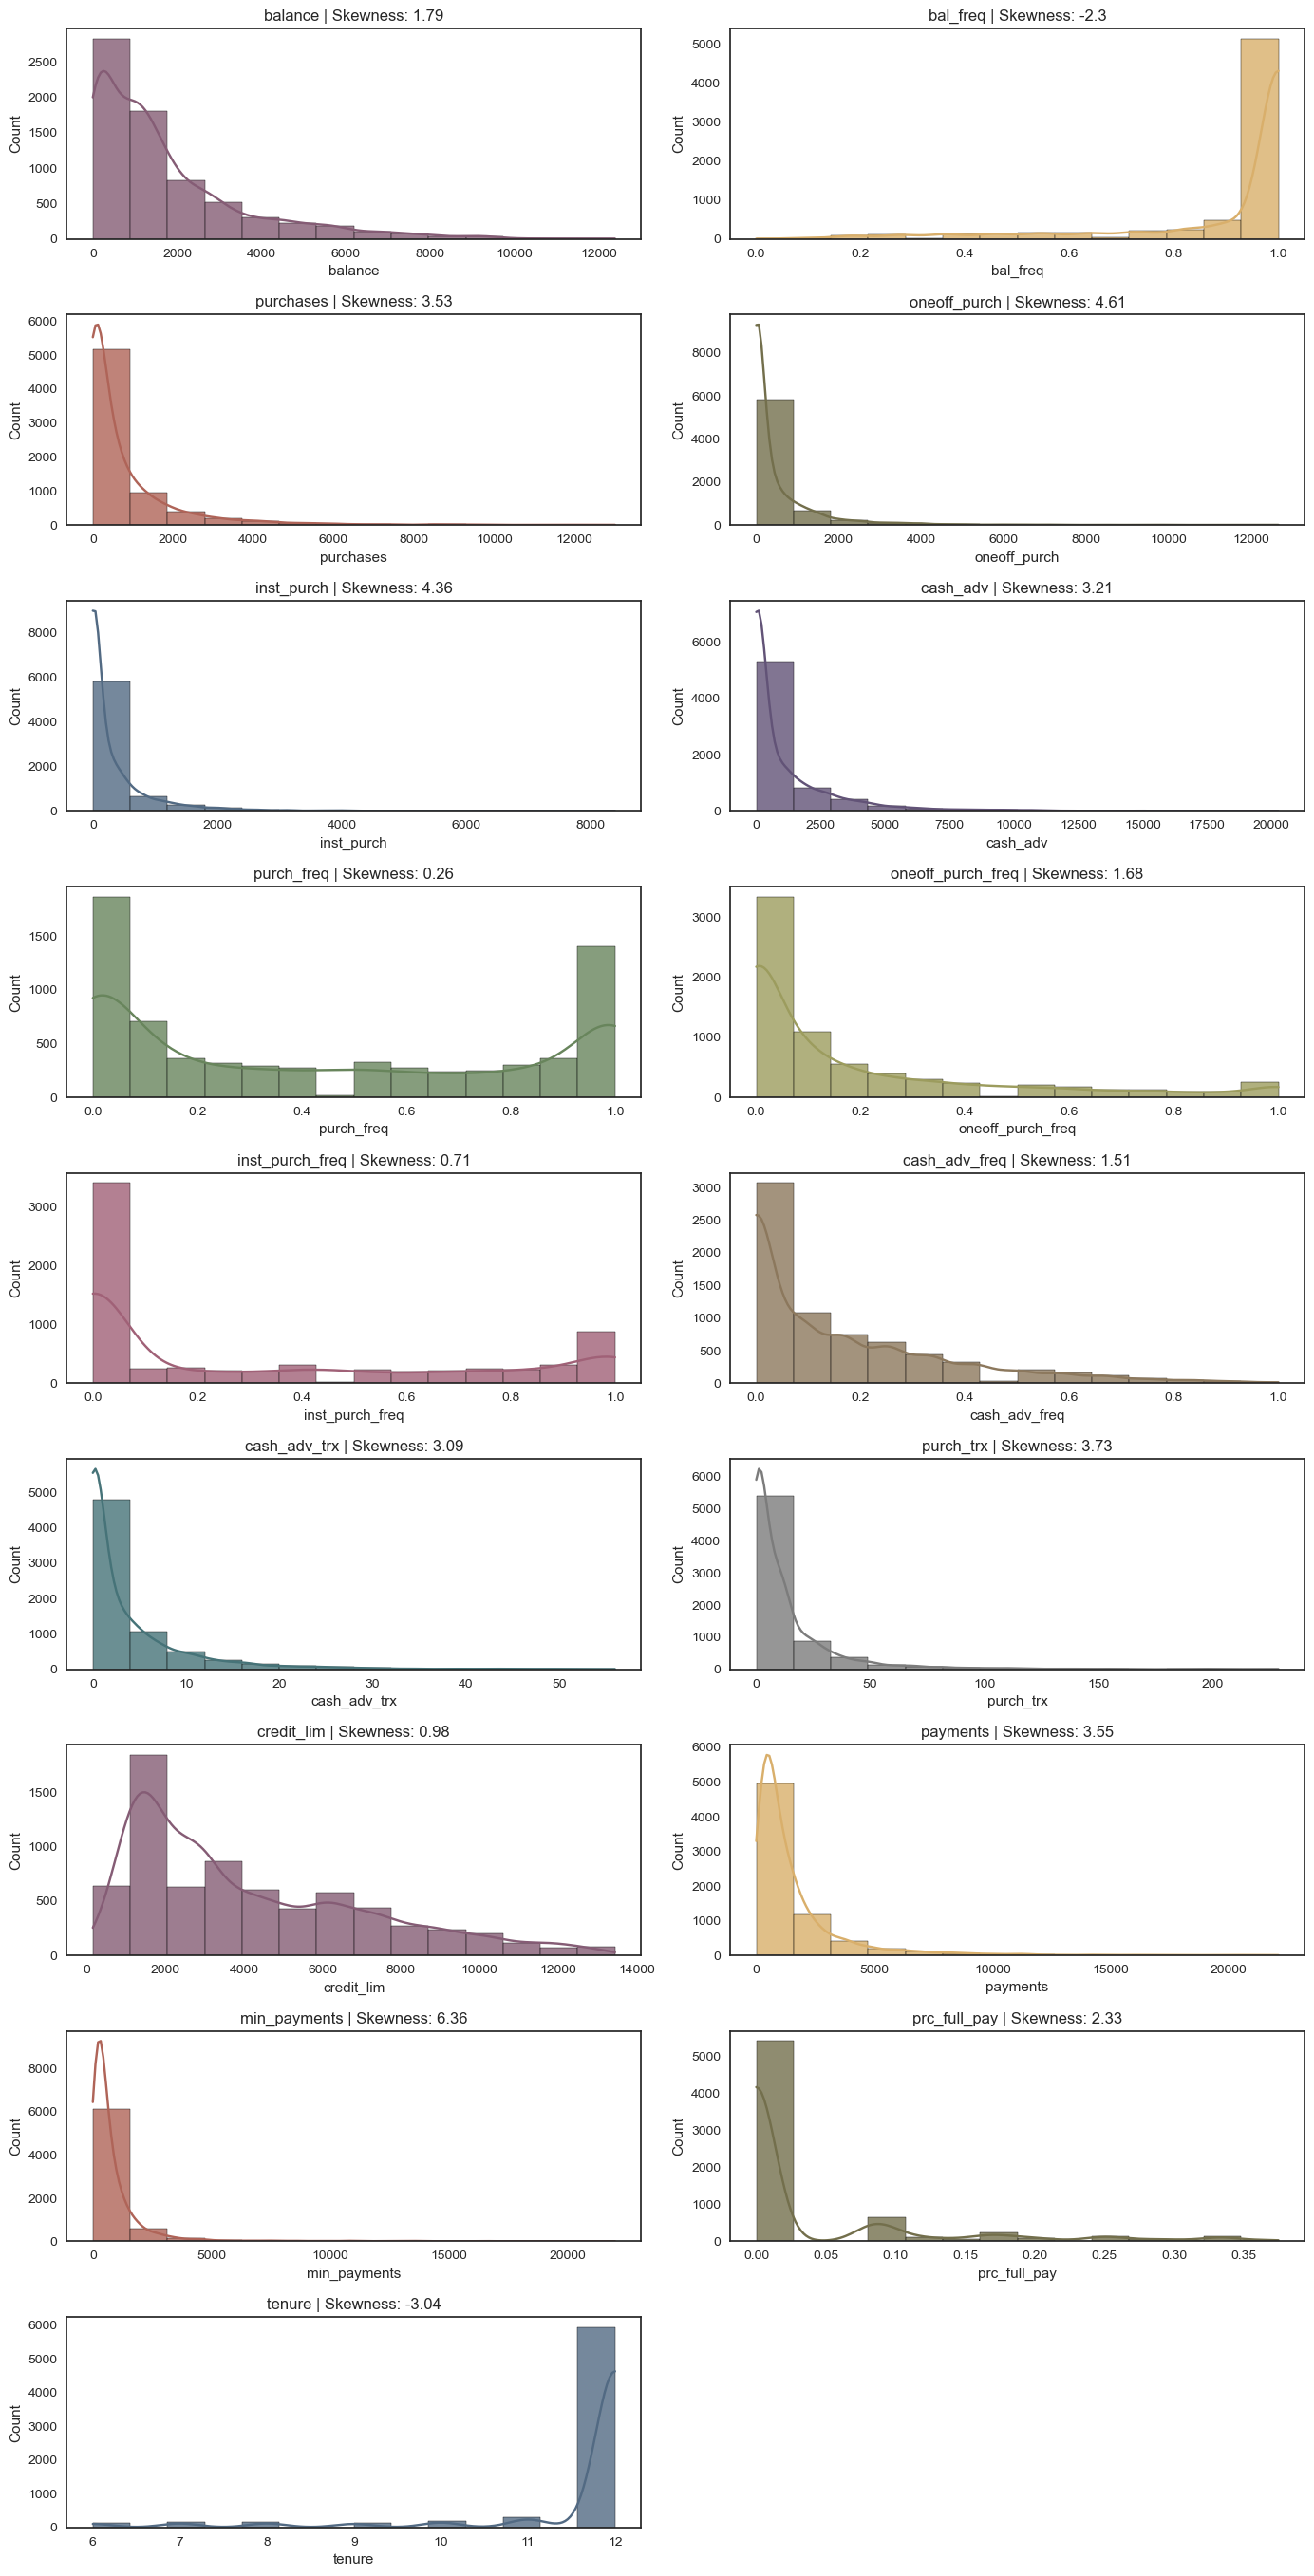

In [75]:
#Vamos a ver la distribucion de las variables numericas con tal de ver si hay algun sesgo y corregirlo 
num_columns = df.select_dtypes(include = ['int64', 'float64']).columns

sns.set_style('white')
plt.figure(figsize = (14, len(num_columns) * 3))

for idx, feature in enumerate(num_columns, 1):
    plt.subplot(len(num_columns), 2, idx)
    color_idx = (idx - 1) % len(antique_palette)
    sns.histplot(df[feature], bins = 'sturges', kde = True, color = antique_palette[color_idx], alpha = 0.8, 
                     edgecolor = 'black')
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

In [76]:
#Se le aplica una transformacion de cuantil para algunas variables con el proposito de reducir el impacto de valores atipicos 
qt_normal = QuantileTransformer(n_quantiles = 100, output_distribution = 'normal')

qt_normal_col = ['balance', 'credit_lim','payments', 'min_payments']

for feature in qt_normal_col:
    df[feature] = qt_normal.fit_transform(df[[feature]])

In [77]:
#Se le aplica una transformacion Yeo-Johnson para estabilizar la varianza y que tengan una distribucion mas normal
yeojohnson_col = list(set(df.columns.to_list()) - set(qt_normal_col))

for feature in yeojohnson_col:
    df[feature], _ = yeojohnson(df[feature])

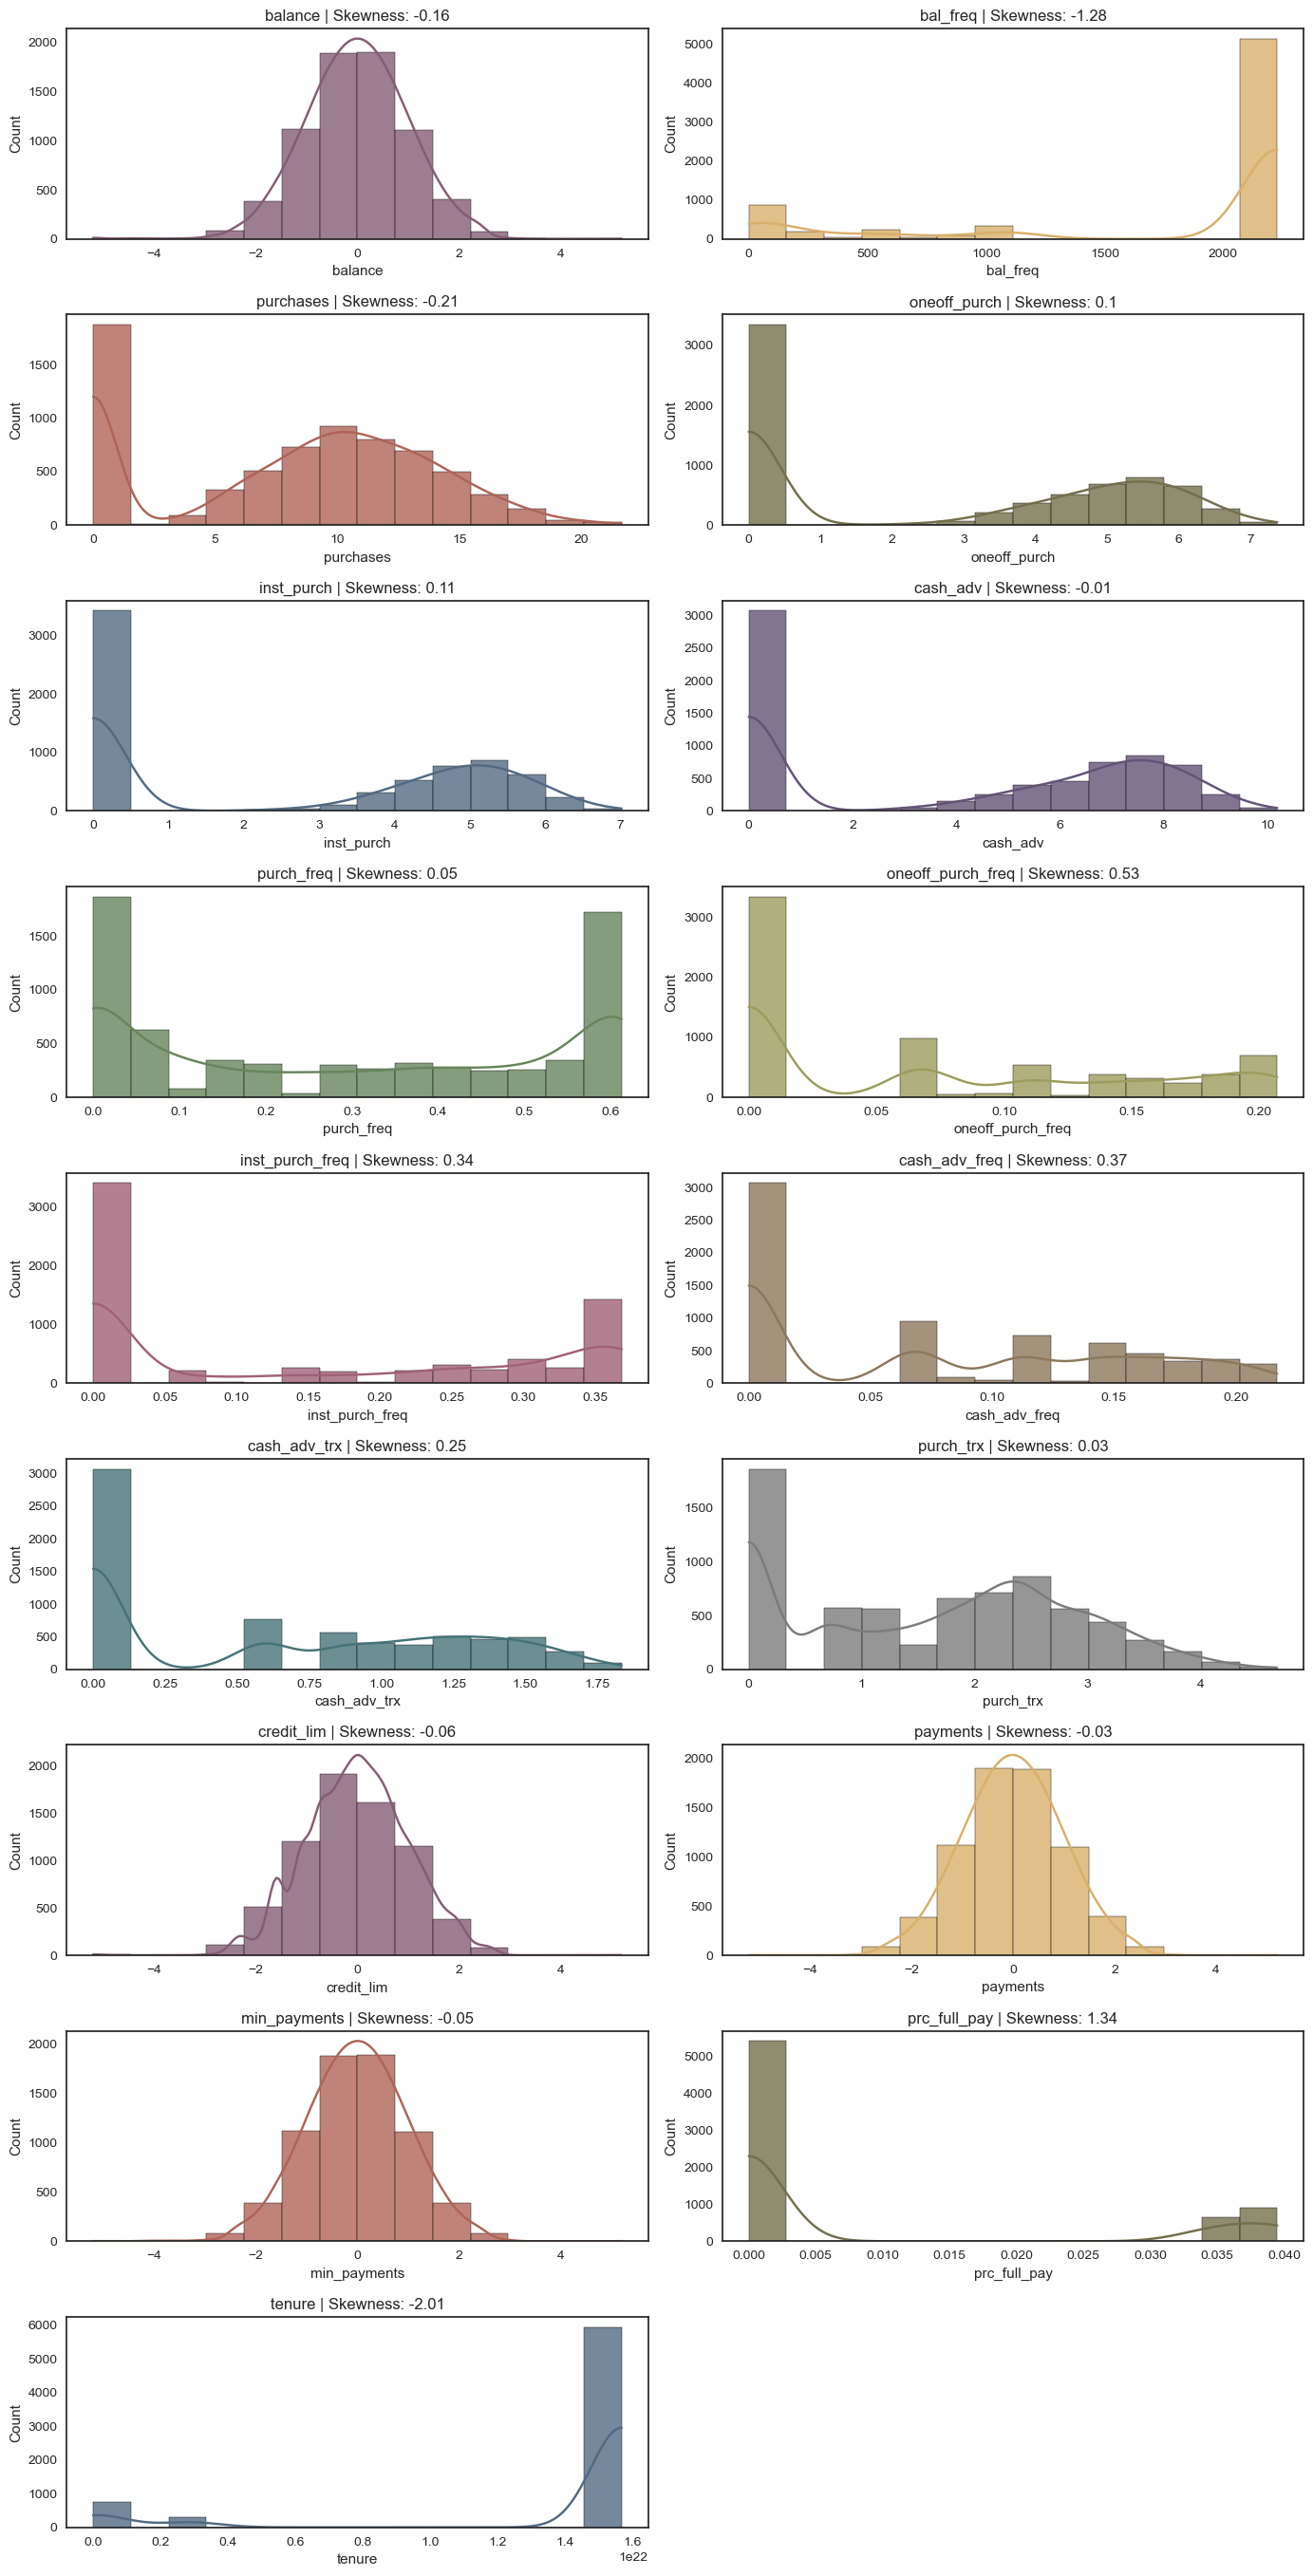

In [78]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns

sns.set_style('white')
plt.figure(figsize=(14, len(num_columns) * 3))

for idx, feature in enumerate(num_columns, 1):
    plt.subplot(len(num_columns), 2, idx)
    color_idx = (idx - 1) % len(antique_palette)
    sns.histplot(df[feature], bins = 'sturges', kde = True, color = antique_palette[color_idx], alpha = 0.8, 
                     edgecolor = 'black')
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

In [82]:
#Escalamos los datos 
scaler = MinMaxScaler()
_df = scaler.fit_transform(df)

<Axes: title={'center': 'Pearson Correlation of Features'}>

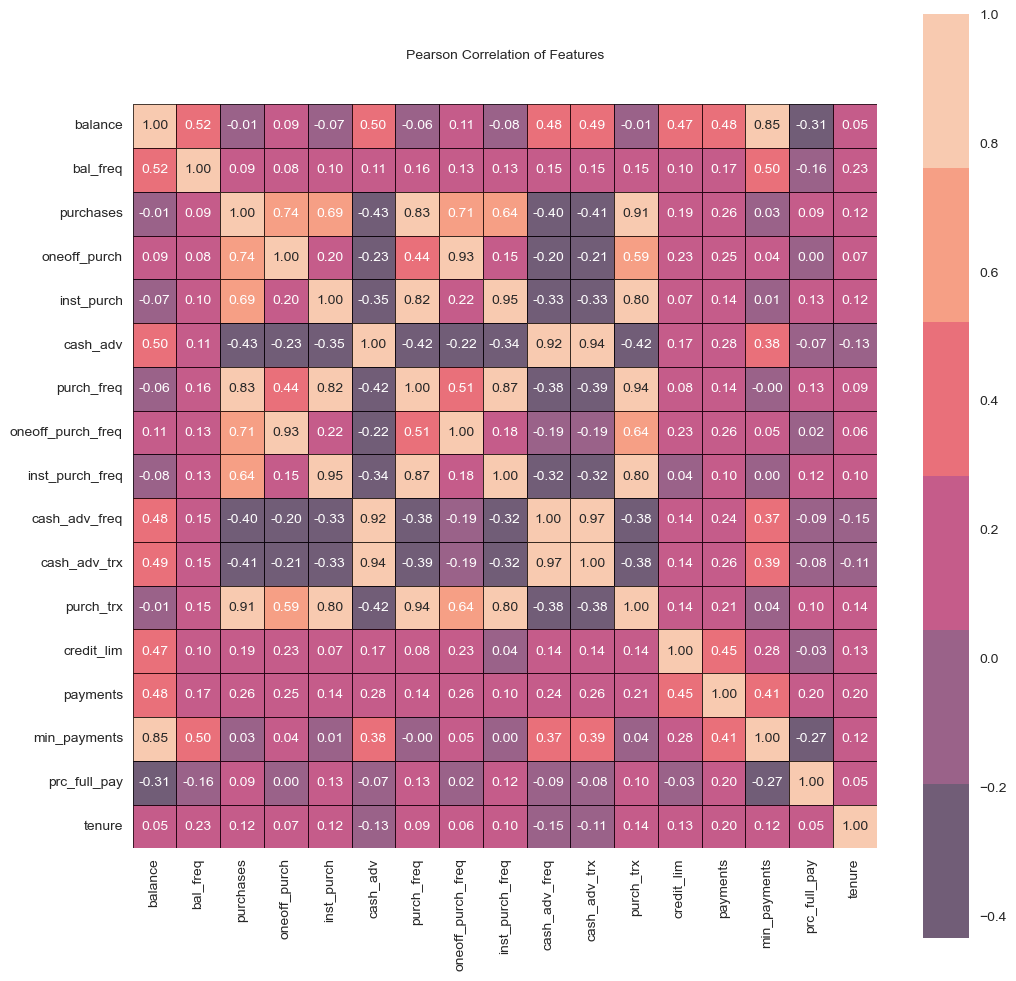

In [83]:
plt.figure(figsize=(12, 12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 10)
sns.heatmap(pd.DataFrame(_df, columns = num_columns).corr(), square = True, linewidths=0.5, linecolor='black', 
            cmap = sns.color_palette(palette='rocket'), annot = True, annot_kws = {"size": 10}, alpha = 0.7, fmt = '.2f')

In [85]:
#Despues de ver la matriz de correlacion decidi quitar varias variables que estaban muy relacionadas o no aportaban mucha informacion al modelo
_df = np.delete(_df, np.s_[1, 2, 7, 8, 9, 10, 11, 15, 16], axis = 1) 
df = pd.DataFrame(_df)
#df = df.drop(['bal_freq', 'purchases', 'oneoff_purch_freq', 'inst_purch_freq', 'cash_adv_freq',
              #'cash_adv_trx', 'prc_full_pay', 'tenure'], axis='columns')

In [101]:
old_names = df.columns.tolist()
new_names = ['balance','purchases','oneoff_purch','inst_purch','cash_adv','purch_trx','credit_lim','payments','min_payments']

df.rename(columns = dict(zip(old_names, new_names)), inplace = True)

In [102]:
df.head()

,balance,purchases,oneoff_purch,inst_purch,cash_adv,purch_trx,credit_lim,payments
0,0.371800,0.000000,0.571416,0.000000,0.244676,0.346786,0.375253,0.393747
1,0.594806,0.000000,0.000000,0.881663,0.000000,0.587363,0.635660,0.578293
2,0.570299,0.756096,0.000000,0.000000,1.000000,0.599047,0.474830,0.534213
3,0.471864,0.356017,0.000000,0.000000,0.128758,0.392274,0.482167,0.461258
4,0.543129,0.000000,0.837019,0.000000,0.760886,0.447604,0.543069,0.646071


In [103]:
#df.to_csv('HC_Clean.csv', index= False)